In [1]:
!pip install kaggle

# **Setup Kaggle API and Download Dataset**

In [2]:
from google.colab import files

uploaded = files.upload()   # upload kaggle.json

import os
import shutil

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

print("Kaggle API key successfully installed!")



Saving kaggle.json to kaggle.json
Kaggle API key successfully installed!


In [3]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
  0% 0.00/121M [00:00<?, ?B/s]
100% 121M/121M [00:00<00:00, 1.74GB/s]


In [4]:
!unzip -q face-expression-recognition-dataset.zip
!ls -la

total 123428
drwxr-xr-x 1 root root      4096 Nov 24 18:26 .
drwxr-xr-x 1 root root      4096 Nov 24 18:21 ..
drwxr-xr-x 4 root root      4096 Nov 20 14:30 .config
-rw-r--r-- 1 root root 126358582 Oct 17  2019 face-expression-recognition-dataset.zip
drwxr-xr-x 5 root root      4096 Nov 24 18:26 images
-rw-r--r-- 1 root root        63 Nov 24 18:26 kaggle.json
drwxr-xr-x 1 root root      4096 Nov 20 14:30 sample_data


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import gradio as gr

# 1. **Dataset Preparation**

In [6]:
dataset_path = '/content/images'

train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

if not os.path.exists(train_dir):
    print(f"Training directory not found at {train_dir}")
    print("Please ensure the dataset has been downloaded and the path is correct")
    exit()

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['happy', 'sad']
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['happy', 'sad']
)

print(f"Number of Training Samples: {train_generator.samples}")
print(f"Number of Validation Samples: {validation_generator.samples}")
print(f"Class Indices: {train_generator.class_indices}")

Found 12102 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.
Number of Training Samples: 12102
Number of Validation Samples: 2964
Class Indices: {'happy': 0, 'sad': 1}


In [7]:
dataset_path = '/content/images'
subdirs = os.listdir(dataset_path)
print("Main directories:", subdirs)

for subdir in subdirs:
    full_path = os.path.join(dataset_path, subdir)
    if os.path.isdir(full_path):
        print(f"\n{subdir} contains:")
        emotion_classes = os.listdir(full_path)
        print(emotion_classes)

Main directories: ['images', 'train', 'validation']

images contains:
['train', 'validation']

train contains:
['disgust', 'neutral', 'surprise', 'fear', 'angry', 'happy', 'sad']

validation contains:
['disgust', 'neutral', 'surprise', 'fear', 'angry', 'happy', 'sad']


#**Count Images Per Class in Each Split**

In [8]:
def count_images_per_class(directory, emotion_classes_list):
    counts = {}

    for emotion in emotion_classes_list:
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path) and os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
        else:
            counts[emotion] = 0
    return counts

train_counts = count_images_per_class(train_dir, emotion_classes)
val_counts = count_images_per_class(validation_dir, emotion_classes)


print("Training set counts:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal training images:", sum(train_counts.values()))

print("\nValidation set counts:")
for emotion, count in val_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal validation images:", sum(val_counts.values()))

Training set counts:
disgust: 436
neutral: 4982
surprise: 3205
fear: 4103
angry: 3993
happy: 7164
sad: 4938

Total training images: 28821

Validation set counts:
disgust: 111
neutral: 1216
surprise: 797
fear: 1018
angry: 960
happy: 1825
sad: 1139

Total validation images: 7066


#**EDA**

In [12]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def count_images_per_class(directory, emotion_classes_list):
    counts = {}

    for emotion in emotion_classes_list:
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path) and os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
        else:
            counts[emotion] = 0
    return counts


train_counts = count_images_per_class(train_dir, emotion_classes)
val_counts = count_images_per_class(validation_dir, emotion_classes)

# Print counts
print("Training set counts:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal training images:", sum(train_counts.values()))

print("\nValidation set counts:")
for emotion, count in val_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal validation images:", sum(val_counts.values()))





Training set counts:
disgust: 436
neutral: 4982
surprise: 3205
fear: 4103
angry: 3993
happy: 7164
sad: 4938

Total training images: 28821

Validation set counts:
disgust: 111
neutral: 1216
surprise: 797
fear: 1018
angry: 960
happy: 1825
sad: 1139

Total validation images: 7066


In [13]:
df_counts = pd.DataFrame({
    "Emotion": emotion_classes,
    "Train Count": [train_counts[e] for e in emotion_classes],
    "Validation Count": [val_counts[e] for e in emotion_classes]
})

print("\nClass Distribution DataFrame:")
print(df_counts)





Class Distribution DataFrame:
    Emotion  Train Count  Validation Count
0   disgust          436               111
1   neutral         4982              1216
2  surprise         3205               797
3      fear         4103              1018
4     angry         3993               960
5     happy         7164              1825
6       sad         4938              1139


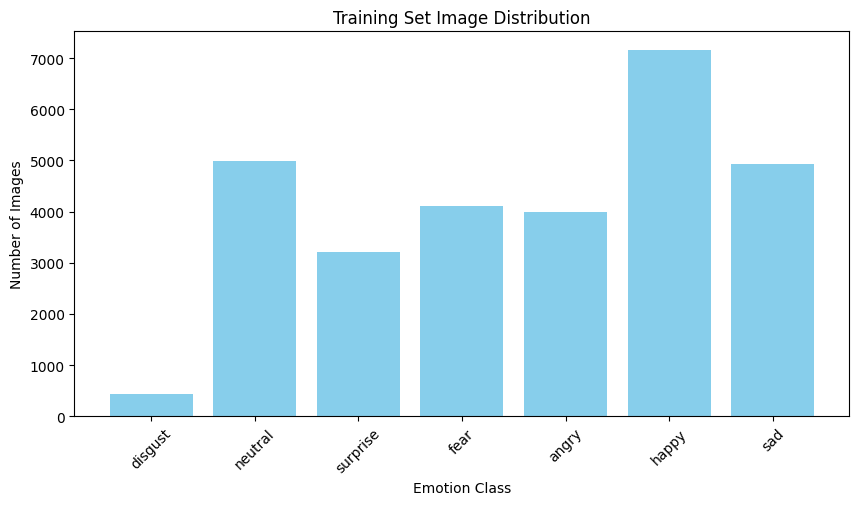

In [14]:
plt.figure(figsize=(10, 5))
plt.bar(df_counts["Emotion"], df_counts["Train Count"], color='skyblue')
plt.title("Training Set Image Distribution")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()




In [20]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = "/content/images"     # change if needed

train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")

# Auto-detect available emotion classes
emotion_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

print("Detected emotion classes:", emotion_classes)


Detected emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [21]:
def get_all_image_paths(dataset_path, emotion_classes):
    image_paths = []

    for split in ["train", "validation"]:
        split_dir = os.path.join(dataset_path, split)

        for emotion in emotion_classes:
            emotion_path = os.path.join(split_dir, emotion)

            if not os.path.exists(emotion_path):
                print(f"Skipping missing folder: {emotion_path}")
                continue

            for img_name in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_name)
                image_paths.append((emotion, img_path))

    return image_paths


all_images = get_all_image_paths(dataset_path, emotion_classes)
len(all_images)


35887

In [30]:
import os
import pandas as pd
from PIL import Image
dataset_path = "/content/images"
train_dir = os.path.join(dataset_path, "train")
emotion_classes = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])

print("Detected emotion classes:", emotion_classes)
all_images = []

for split in ["train", "validation"]:
    split_dir = os.path.join(dataset_path, split)

    for emotion in emotion_classes:
        emotion_path = os.path.join(split_dir, emotion)

        if not os.path.exists(emotion_path):
            continue

        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            all_images.append((emotion, img_path))
sizes = []

for emotion, img_path in all_images:
    try:
        img = Image.open(img_path)
        sizes.append([emotion, img.width, img.height])
    except:
        pass

df_sizes = pd.DataFrame(sizes, columns=["Emotion", "Width", "Height"])
print("\nExample rows:")
print(df_sizes.head())

avg_size_per_class = df_sizes.groupby("Emotion")[["Width", "Height"]].mean()

mode_size_per_class = (
    df_sizes.groupby(["Emotion", "Width", "Height"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Emotion", "Count"], ascending=[True, False])
)

print("\nAverage size per class:")
print(avg_size_per_class)

print("\nMost common shape per class:")
for emotion in emotion_classes:
    row = mode_size_per_class[mode_size_per_class["Emotion"] == emotion].head(1)
    print(f"{emotion}: {int(row.Width)}x{int(row.Height)} (count={int(row.Count)})")



Detected emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Example rows:
  Emotion  Width  Height
0   angry     48      48
1   angry     48      48
2   angry     48      48
3   angry     48      48
4   angry     48      48

Average size per class:
          Width  Height
Emotion                
angry      48.0    48.0
disgust    48.0    48.0
fear       48.0    48.0
happy      48.0    48.0
neutral    48.0    48.0
sad        48.0    48.0
surprise   48.0    48.0

Most common shape per class:
angry: 48x48 (count=4953)
disgust: 48x48 (count=547)
fear: 48x48 (count=5121)
happy: 48x48 (count=8989)
neutral: 48x48 (count=6198)
sad: 48x48 (count=6077)
surprise: 48x48 (count=4002)


/tmp/ipython-input-3627625676.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f"{emotion}: {int(row.Width)}x{int(row.Height)} (count={int(row.Count)})")


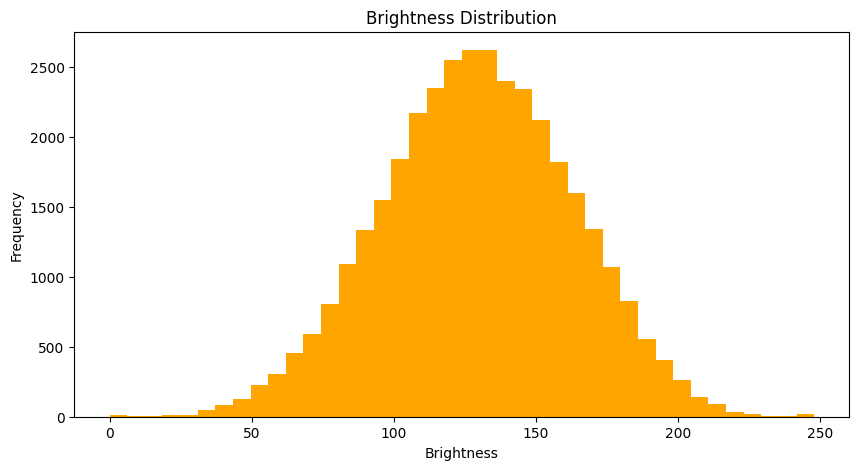

In [25]:
def image_brightness(img):
    return np.array(img.convert("L")).mean()

brightness_values = []
for emotion, img_path in all_images:
    try:
        img = Image.open(img_path)
        brightness_values.append(image_brightness(img))
    except:
        pass

plt.figure(figsize=(10,5))
plt.hist(brightness_values, bins=40, color="orange")
plt.title("Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()


# **Display Sample Images from Each Class**

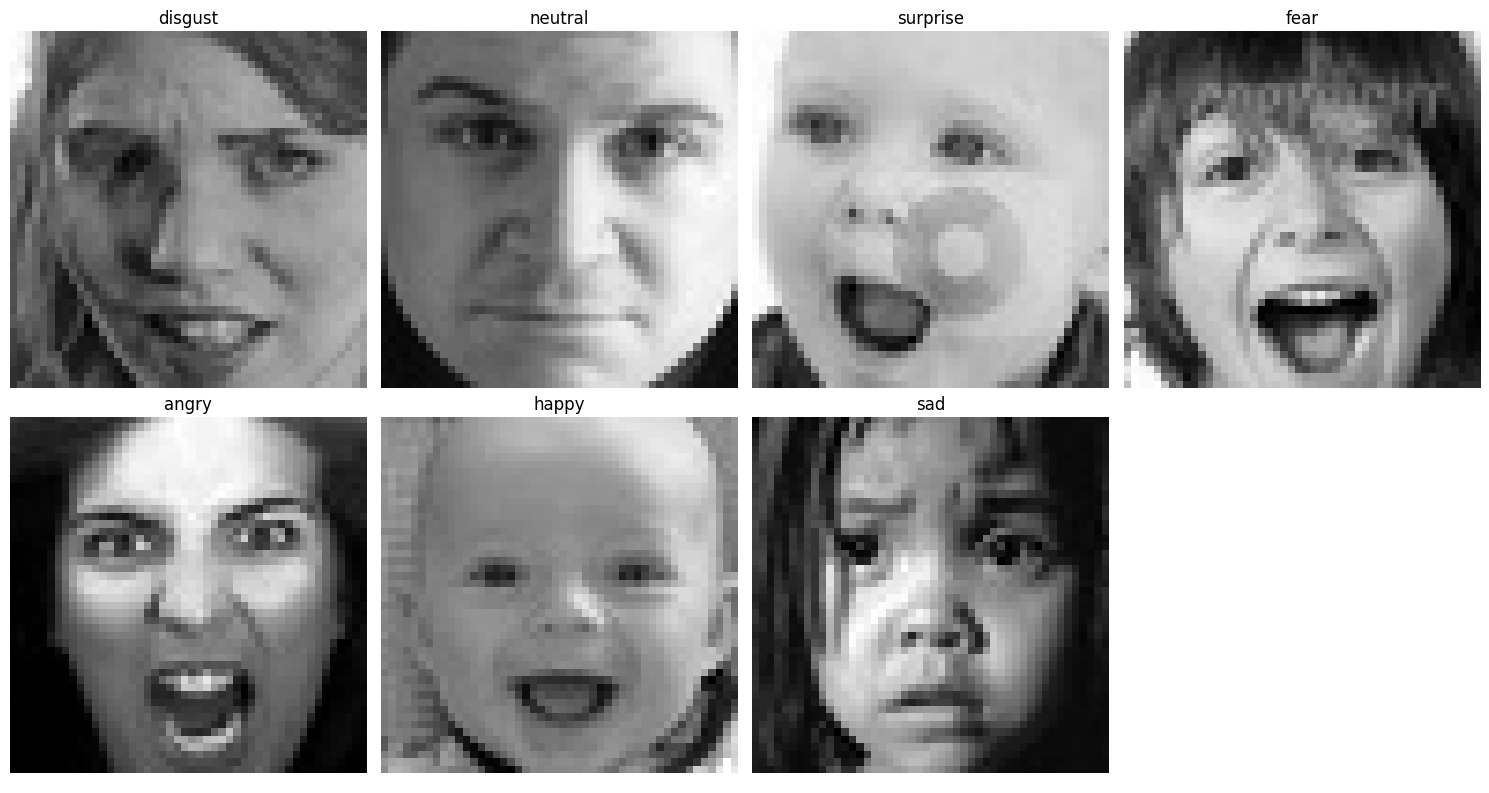

In [9]:
import random

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, emotion in enumerate(emotion_classes[:7]):
    emotion_path = os.path.join(train_dir, emotion)
    image_files = os.listdir(emotion_path)
    sample_image = random.choice(image_files)
    img_path = os.path.join(emotion_path, sample_image)

    img = Image.open(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(emotion)
    axes[i].axis('off')

axes[7].axis('off')
plt.tight_layout()
plt.show()


#  **Histogram Equalization for Contrast Enhancement**

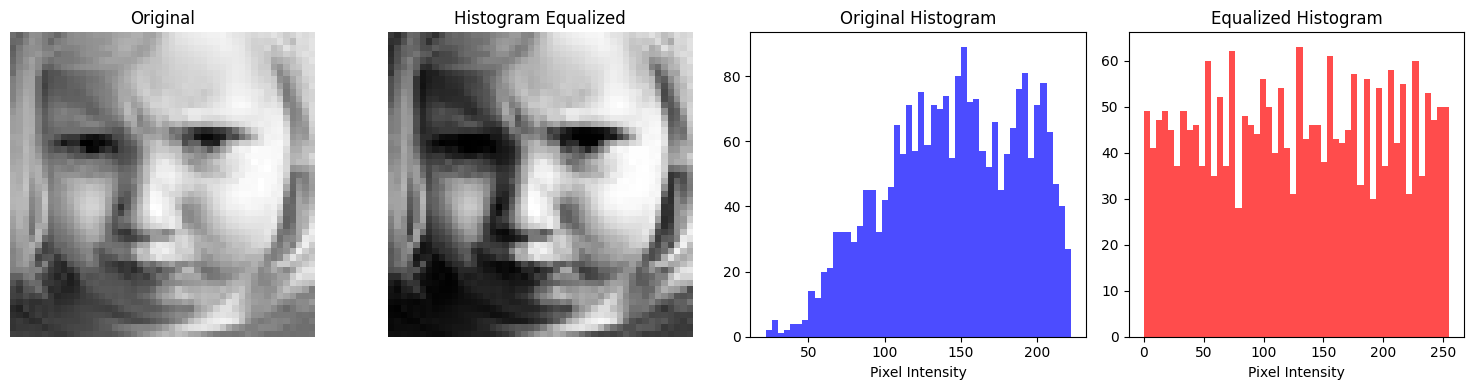

In [10]:
import cv2

def apply_histogram_equalization(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    equalized = cv2.equalizeHist(img)
    return img, equalized

sample_emotion = emotion_classes[0]
sample_path = os.path.join(train_dir, sample_emotion)
sample_file = os.listdir(sample_path)[0]
img_path = os.path.join(sample_path, sample_file)

original, equalized = apply_histogram_equalization(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(equalized, cmap='gray')
axes[1].set_title('Histogram Equalized')
axes[1].axis('off')

axes[2].hist(original.flatten(), bins=50, alpha=0.7, color='blue')
axes[2].set_title('Original Histogram')
axes[2].set_xlabel('Pixel Intensity')

axes[3].hist(equalized.flatten(), bins=50, alpha=0.7, color='red')
axes[3].set_title('Equalized Histogram')
axes[3].set_xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()

 # **Gaussian Blur for Noise Reduction**

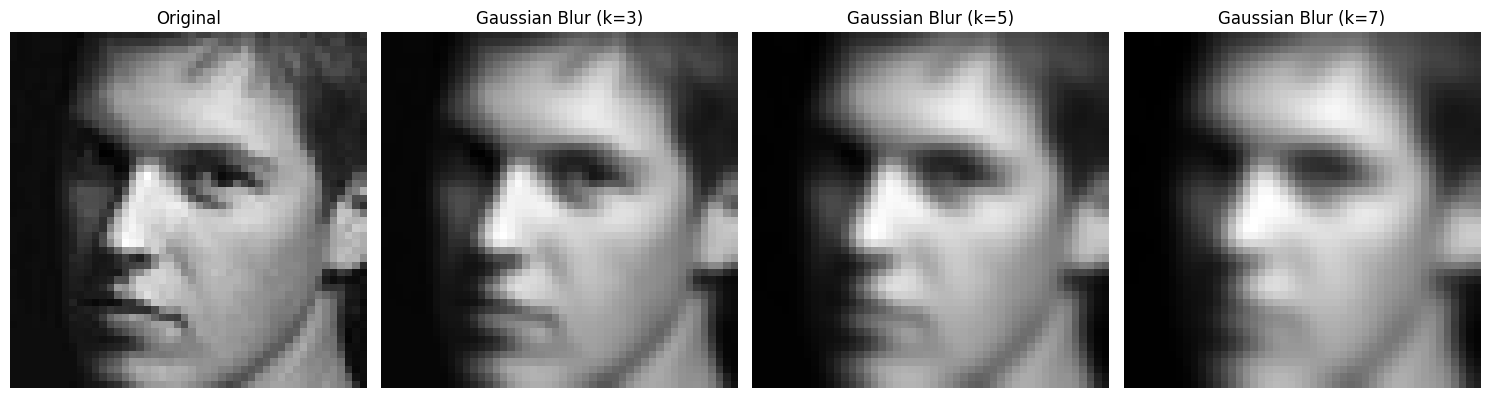

In [ ]:
def apply_gaussian_blur(image_path, kernel_sizes=[3, 5, 7]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_images = []

    for kernel_size in kernel_sizes:
        blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)

    return img, blurred_images

original, blurred_list = apply_gaussian_blur(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

for i, (blurred, kernel_size) in enumerate(zip(blurred_list, [3, 5, 7])):
    axes[i+1].imshow(blurred, cmap='gray')
    axes[i+1].set_title(f'Gaussian Blur (k={kernel_size})')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


# **Edge Detection with Canny Filter**

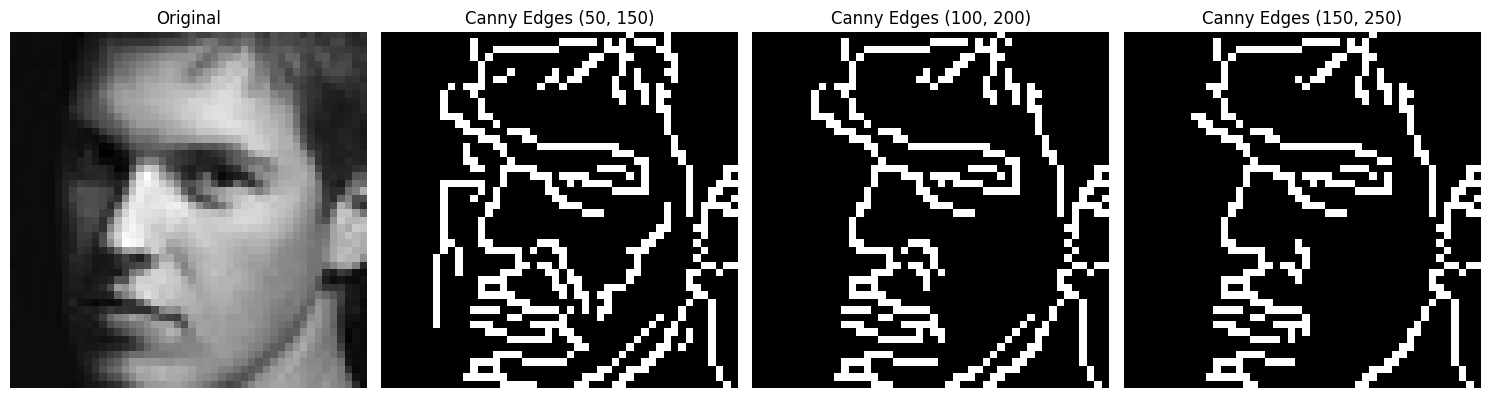

In [ ]:
def apply_canny_edge_detection(image_path, thresholds=[(50, 150), (100, 200), (150, 250)]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edge_images = []

    for low_thresh, high_thresh in thresholds:
        edges = cv2.Canny(img, low_thresh, high_thresh)
        edge_images.append(edges)

    return img, edge_images

original, edges_list = apply_canny_edge_detection(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

thresholds = [(50, 150), (100, 200), (150, 250)]
for i, (edges, thresh) in enumerate(zip(edges_list, thresholds)):
    axes[i+1].imshow(edges, cmap='gray')
    axes[i+1].set_title(f'Canny Edges {thresh}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


 # **Morphologica**l **Operations**

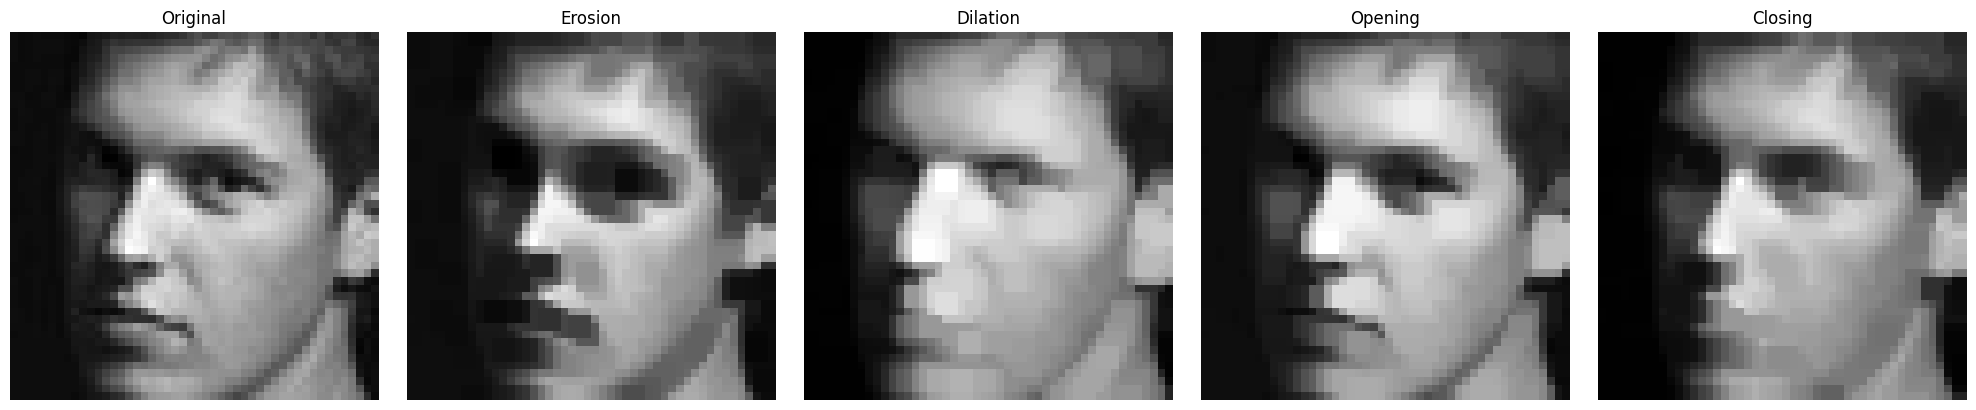

In [ ]:
def apply_morphological_operations(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    kernel = np.ones((3,3), np.uint8)

    erosion = cv2.erode(img, kernel, iterations=1)
    dilation = cv2.dilate(img, kernel, iterations=1)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    return img, erosion, dilation, opening, closing

results = apply_morphological_operations(img_path)
titles = ['Original', 'Erosion', 'Dilation', 'Opening', 'Closing']

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, (result, title) in enumerate(zip(results, titles)):
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


 # **Adaptive Thresholding**

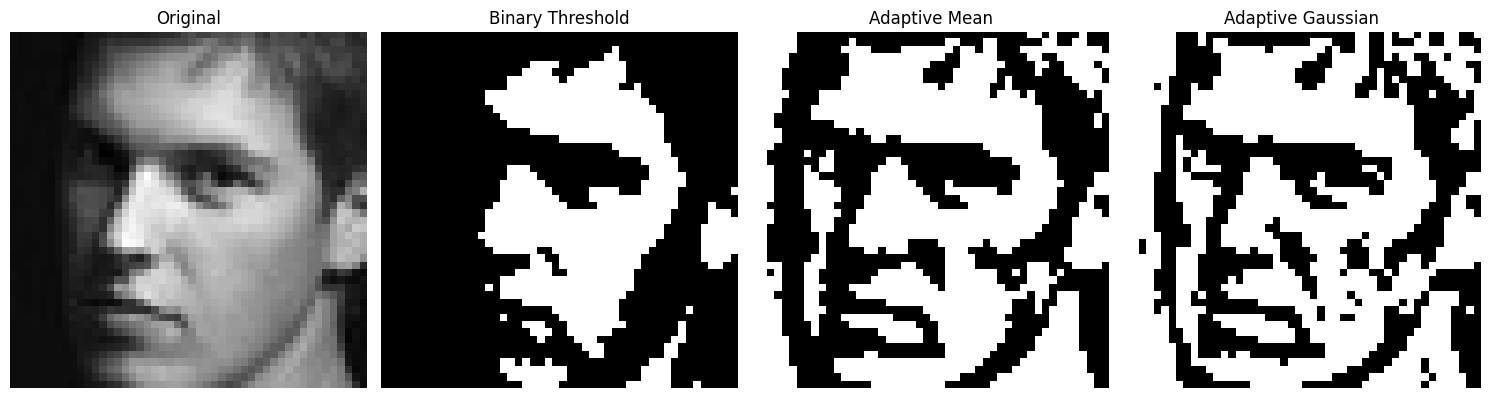

In [ ]:
def apply_adaptive_thresholding(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    ret, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    adaptive_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    adaptive_gaussian = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return img, binary, adaptive_mean, adaptive_gaussian

original, binary, adaptive_mean, adaptive_gaussian = apply_adaptive_thresholding(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
images = [original, binary, adaptive_mean, adaptive_gaussian]
titles = ['Original', 'Binary Threshold', 'Adaptive Mean', 'Adaptive Gaussian']

for i, (img, title) in enumerate(zip(images, titles)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


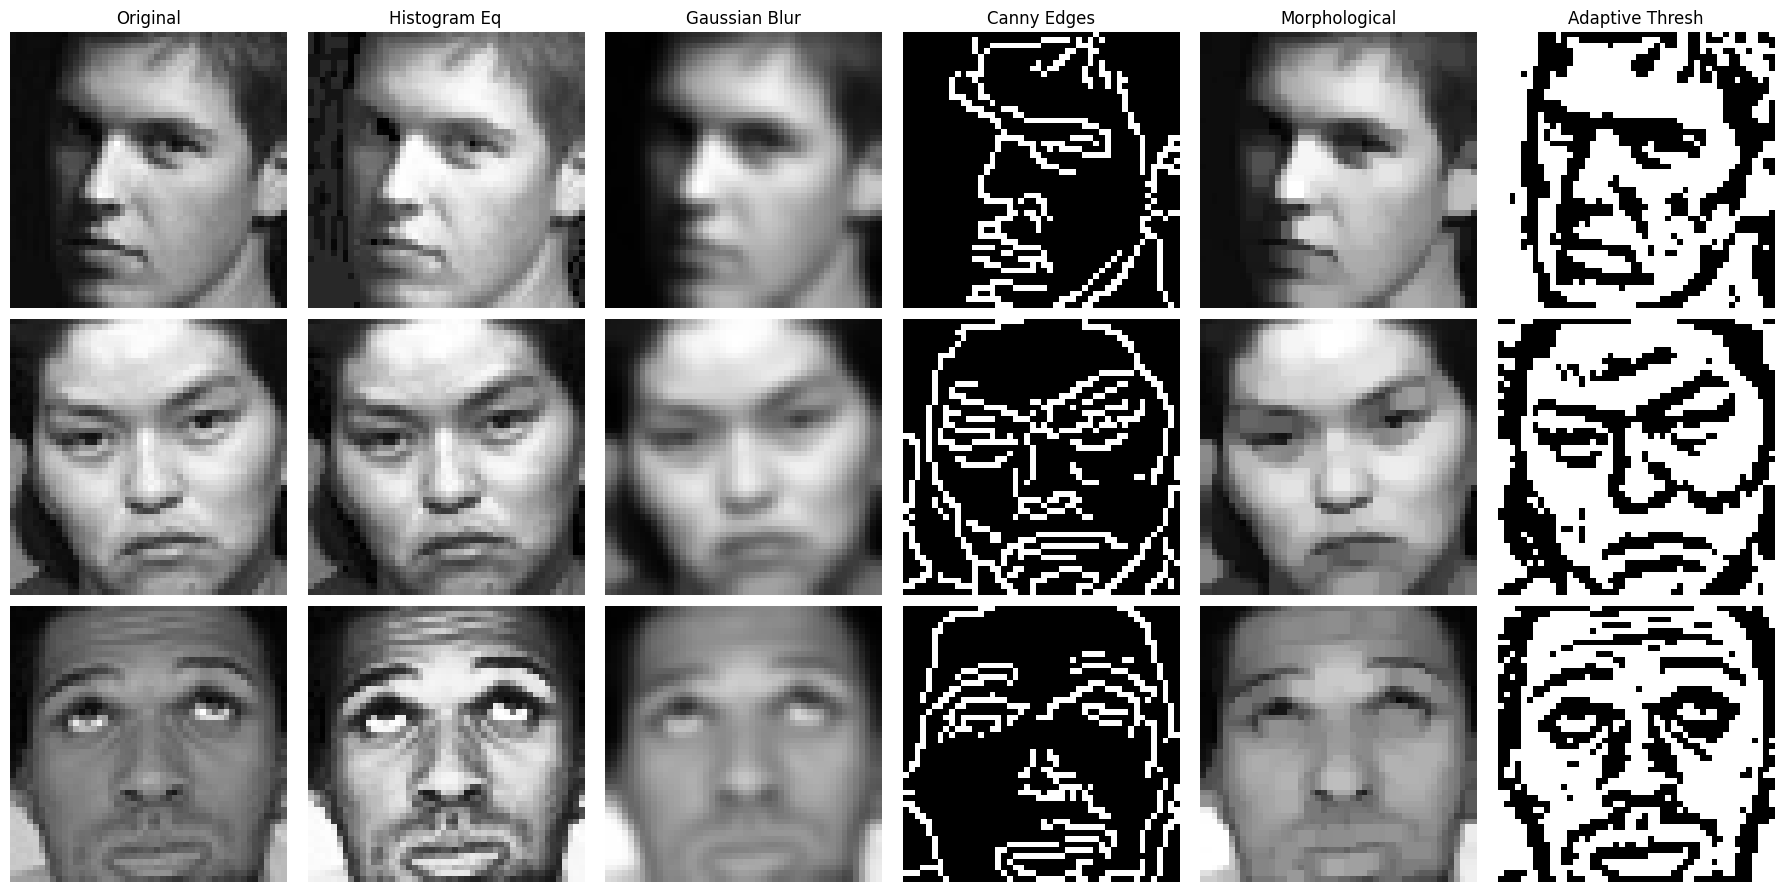

In [ ]:
sample_images = []
for emotion in emotion_classes[:3]:
    emotion_path = os.path.join(train_dir, emotion)
    img_file = os.listdir(emotion_path)[0]
    img_path = os.path.join(emotion_path, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    sample_images.append((img, emotion))

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for row, (img, emotion) in enumerate(sample_images):
    equalized = cv2.equalizeHist(img)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(img, 100, 200)
    kernel = np.ones((3,3), np.uint8)
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    processed_images = [img, equalized, blurred, edges, morphed, adaptive]
    titles = ['Original', 'Histogram Eq', 'Gaussian Blur', 'Canny Edges', 'Morphological', 'Adaptive Thresh']

    for col, (processed, title) in enumerate(zip(processed_images, titles)):
        axes[row, col].imshow(processed, cmap='gray')
        if row == 0:
            axes[row, col].set_title(title)
        if col == 0:
            axes[row, col].set_ylabel(emotion, rotation=0, ha='right')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# **Class Distribution**

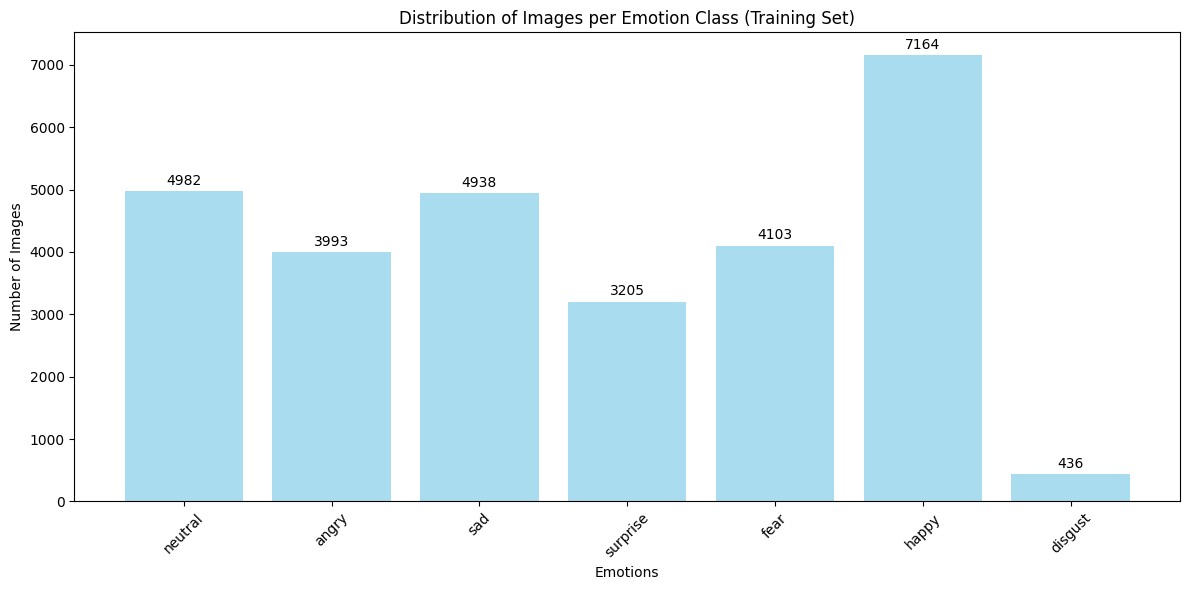

In [ ]:
emotions = list(train_counts.keys())
counts = list(train_counts.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(emotions, counts, color='skyblue', alpha=0.7)
plt.title('Distribution of Images per Emotion Class (Training Set)')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# **Check for Class Imbalance**

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/images'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

emotion_classes = os.listdir(train_dir)
emotion_classes.sort()

def count_images_per_class(directory):
    counts = {}
    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
        else:
            counts[emotion] = 0
    return counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance_ratio = max_count / min_count

print(f"Maximum images in a class: {max_count}")
print(f"Minimum images in a class: {min_count}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2.0:
    print("Significant class imbalance detected. Data augmentation recommended.")
else:
    print("Class distribution is relatively balanced.")

if imbalance_ratio > 2.0:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        fill_mode='nearest',
        preprocessing_function=lambda x: cv2.equalizeHist(x.astype(np.uint8)) if len(x.shape) == 2 else x
    )
    print("Enhanced data augmentation with histogram equalization configured")
else:
    datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=lambda x: cv2.equalizeHist((x*255).astype(np.uint8))/255.0 if len(x.shape) == 2 else x
    )
    print("Basic preprocessing with histogram equalization configured")

Maximum images in a class: 7164
Minimum images in a class: 436
Imbalance ratio: 16.43
Significant class imbalance detected. Data augmentation recommended.
Enhanced data augmentation with histogram equalization configured


# **Analyze Image Properties**

In [ ]:
import random
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def process_image_batch(directory, num_samples=100):
    processed_data = {
        'original': [],
        'histogram_eq': [],
        'gaussian_blur': [],
        'processed_count': 0
    }

    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        image_files = os.listdir(emotion_path)

        sample_size = min(num_samples // len(emotion_classes), len(image_files))
        selected_files = random.sample(image_files, sample_size)

        for img_file in selected_files:
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))

            hist_eq = cv2.equalizeHist(img)
            gaussian = cv2.GaussianBlur(img, (3, 3), 0)

            processed_data['original'].append(img)
            processed_data['histogram_eq'].append(hist_eq)
            processed_data['gaussian_blur'].append(gaussian)
            processed_data['processed_count'] += 1

    return processed_data

processed_batch = process_image_batch(train_dir)
print(f"Processed {processed_batch['processed_count']} images with multiple techniques")

original_mean = np.mean([img.mean() for img in processed_batch['original']])
hist_eq_mean = np.mean([img.mean() for img in processed_batch['histogram_eq']])
gaussian_mean = np.mean([img.mean() for img in processed_batch['gaussian_blur']])

print(f"Average pixel intensity - Original: {original_mean:.2f}")
print(f"Average pixel intensity - Histogram Equalized: {hist_eq_mean:.2f}")
print(f"Average pixel intensity - Gaussian Blurred: {gaussian_mean:.2f}")

Processed 98 images with multiple techniques
Average pixel intensity - Original: 129.78
Average pixel intensity - Histogram Equalized: 127.46
Average pixel intensity - Gaussian Blurred: 129.80


In [ ]:
max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance_ratio = max_count / min_count

print(f"Maximum images in a class: {max_count}")
print(f"Minimum images in a class: {min_count}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2.0:
    print("Significant class imbalance detected. Data augmentation recommended.")
else:
    print("Class distribution is relatively balanced.")


Maximum images in a class: 7164
Minimum images in a class: 436
Imbalance ratio: 16.43
Significant class imbalance detected. Data augmentation recommended.


In [ ]:
def load_sample_images(directory, num_samples=5):
    sample_data = []

    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        image_files = os.listdir(emotion_path)

        samples = random.sample(image_files, min(num_samples, len(image_files)))

        for img_file in samples:
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            sample_data.append({
                'emotion': emotion,
                'image': img,
                'shape': img.shape,
                'size': img.size
            })

    return sample_data

sample_data = load_sample_images(train_dir)
print(f"Loaded {len(sample_data)} sample images")


Loaded 35 sample images


In [ ]:
from collections import Counter

shapes = [data['shape'] for data in sample_data]
sizes = [data['size'] for data in sample_data]

shape_counter = Counter(shapes)
print("Image shapes distribution:")
for shape, count in shape_counter.items():
    print(f"{shape}: {count} images")

print(f"\nAverage image size: {np.mean(sizes):.0f} pixels")
print(f"Image size range: {min(sizes)} - {max(sizes)} pixels")

sample_img = sample_data[0]['image']
print(f"\nSample image details:")
print(f"Shape: {sample_img.shape}")
print(f"Data type: {sample_img.dtype}")
print(f"Min pixel value: {sample_img.min()}")
print(f"Max pixel value: {sample_img.max()}")

Image shapes distribution:
(48, 48): 35 images

Average image size: 2304 pixels
Image size range: 2304 - 2304 pixels

Sample image details:
Shape: (48, 48)
Data type: uint8
Min pixel value: 0
Max pixel value: 240


# **Data Augmentation**

In [ ]:
if imbalance_ratio > 2.0:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        fill_mode='nearest'
    )
    print("Data augmentation configured")
else:
    datagen = ImageDataGenerator(rescale=1./255)
    print("Basic data normalization configured")


Data augmentation configured


# **Data Generators**

In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_dir, # Changed from val_dir to validation_dir
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

print("Data generators created successfully")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Data generators created successfully
Training samples: 28821
Validation samples: 7066
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


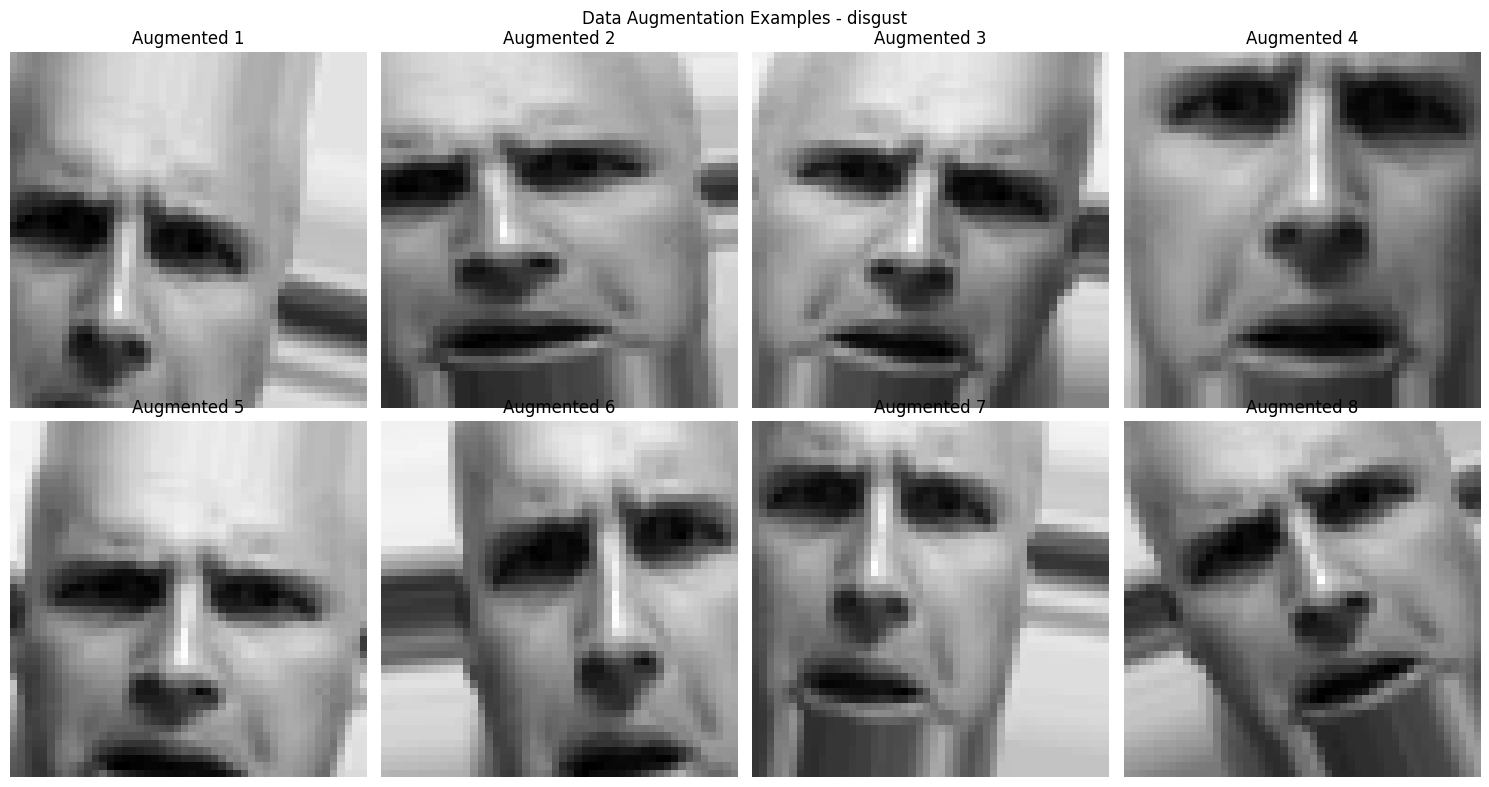

In [ ]:
if imbalance_ratio > 2.0:
    sample_emotion = emotion_classes[1]
    sample_path = os.path.join(train_dir, sample_emotion)
    sample_files = os.listdir(sample_path)

    img = Image.open(os.path.join(sample_path, sample_files[0]))
    img_array = np.array(img).reshape((1,) + img.size + (1,))

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        axes[i].imshow(batch[0].squeeze(), cmap='gray')
        axes[i].set_title(f'Augmented {i+1}')
        axes[i].axis('off')
        i += 1
        if i >= 8:
            break

    plt.suptitle(f'Data Augmentation Examples - {sample_emotion}')
    plt.tight_layout()
    plt.show()


# 2. **Model with Transfer Learning**

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#  **Model Training**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

epochs = 40

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 180s 431ms/step - accuracy: 0.6359 - loss: 0.6439 - val_accuracy: 0.7395 - val_loss: 0.5185 - learning_rate: 1.0000e-04
Epoch 2/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 137s 360ms/step - accuracy: 0.7147 - loss: 0.5539 - val_accuracy: 0.7567 - val_loss: 0.4976 - learning_rate: 1.0000e-04
Epoch 3/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 138s 363ms/step - accuracy: 0.7217 - loss: 0.5392 - val_accuracy: 0.7456 - val_loss: 0.4984 - learning_rate: 1.0000e-04
Epoch 4/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 136s 358ms/step - accuracy: 0.7195 - loss: 0.5355 - val_accuracy: 0.7699 - val_loss: 0.4745 - learning_rate: 1.0000e-04
Epoch 5/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 137s 361ms/step - accuracy: 0.7468 - loss: 0.5179 - val_accuracy: 0.7389 - val_loss: 0.5010 - learning_rate: 1.0000e-04
Epoch 6/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.7398 - loss: 0.5197 - val_accuracy: 0.7669 - val_loss: 0.4670 - learning_rate: 1.0000e-04
Epoch 7/40
379/379 ━━━━━━━━━━━━━━━━━━━━ 

# 4. **Model Evaluation**

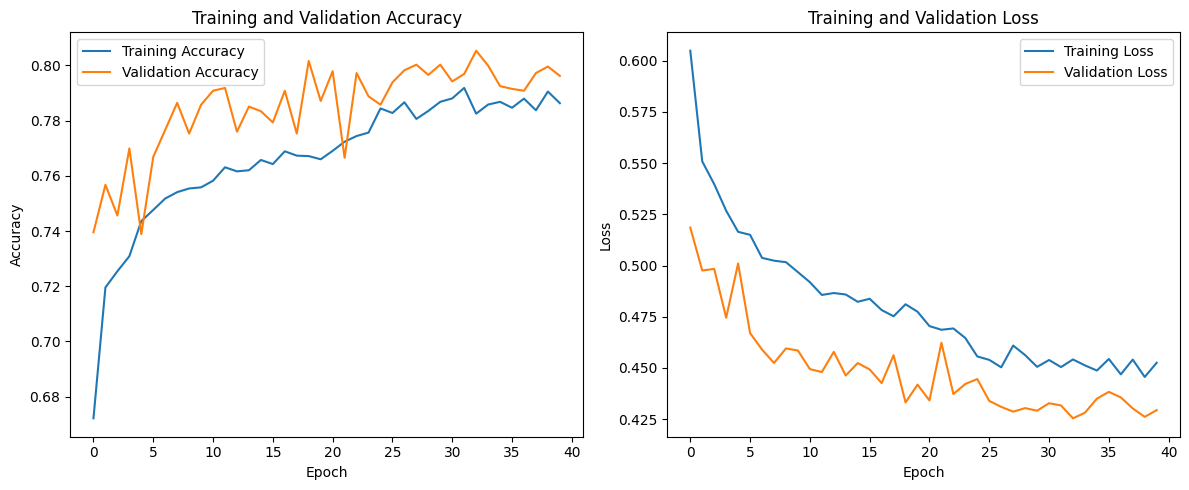

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8028 - loss: 0.4274
Loss on Validation Data: 0.4254
Accuracy on Validation Data: 0.8053


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

loss, accuracy = model.evaluate(validation_generator)
print(f"Loss on Validation Data: {loss:.4f}")
print(f"Accuracy on Validation Data: {accuracy:.4f}")

## **Calculate and plot evaluation metrics**

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


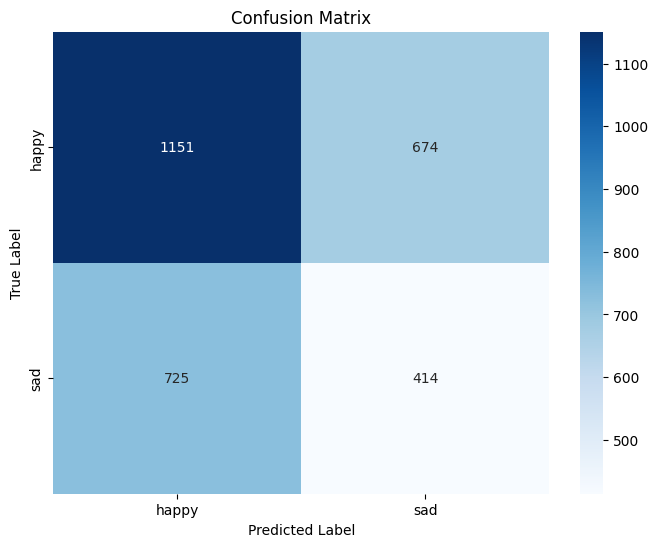

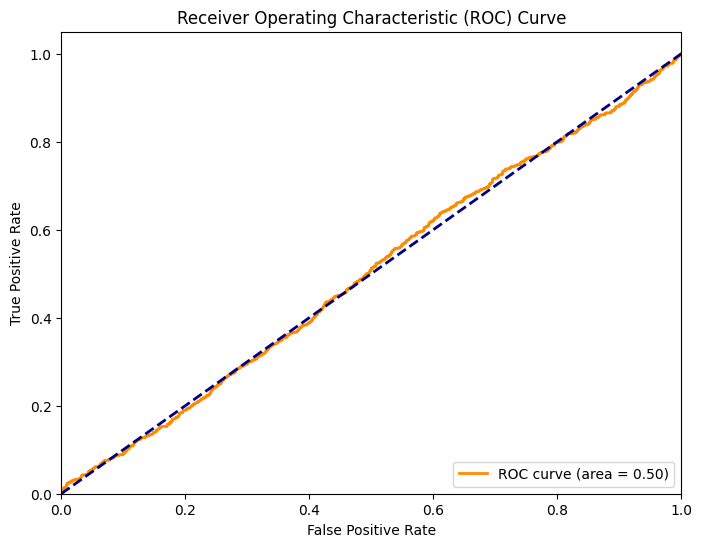

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns


validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = validation_generator.classes


cm = confusion_matrix(y_true, y_pred)


report = classification_report(y_true, y_pred, target_names=['happy', 'sad'], output_dict=True)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['happy', 'sad'], yticklabels=['happy', 'sad'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


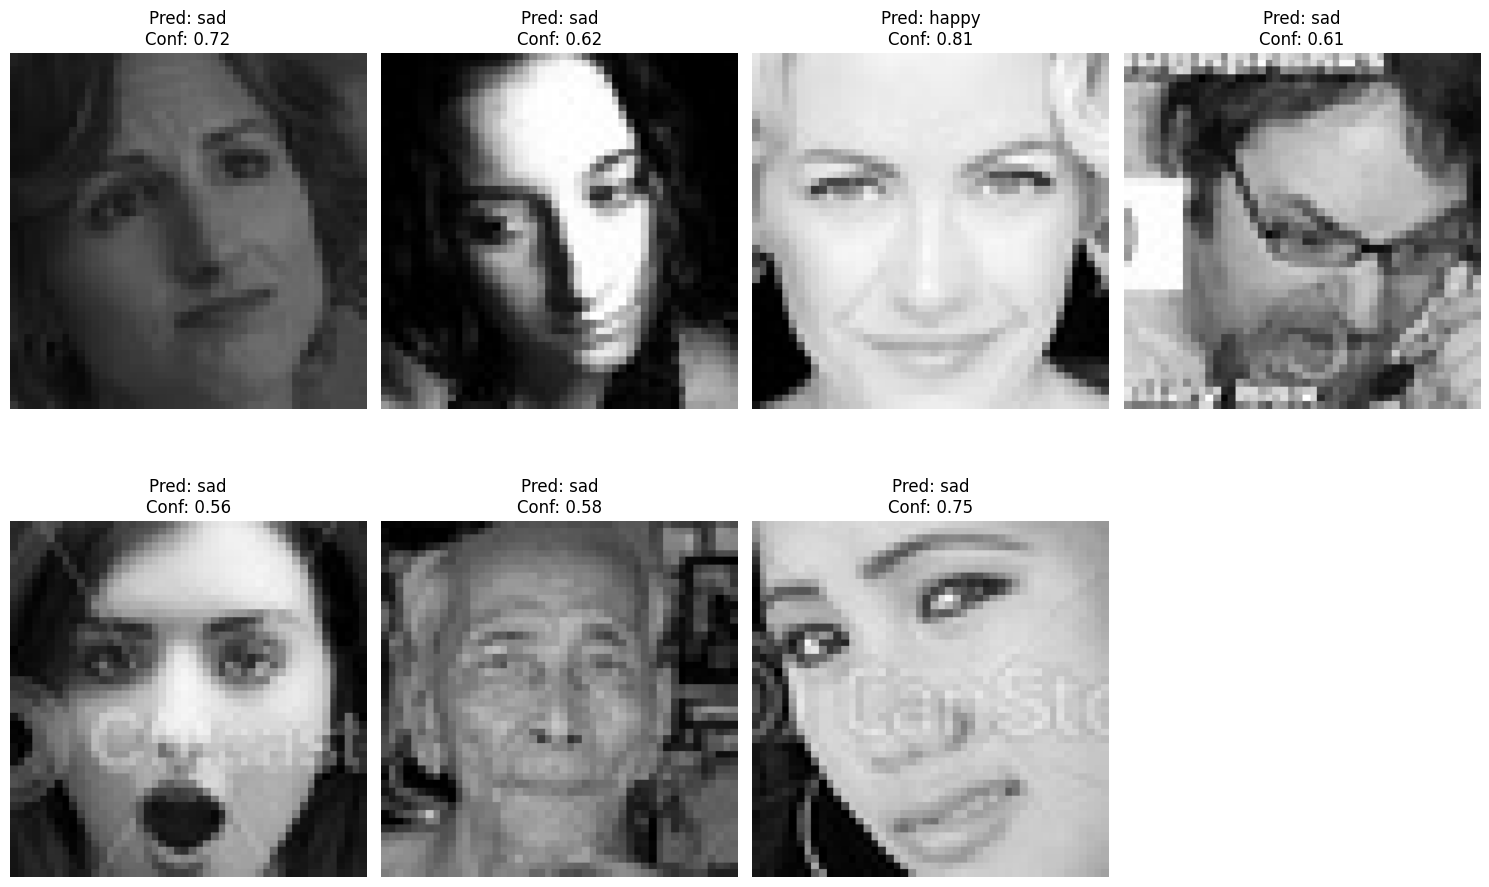

In [ ]:
import random
import numpy as np
from tensorflow.keras.preprocessing import image

model_class_names = list(train_generator.class_indices.keys())


validation_classes = [d for d in os.listdir(validation_dir) if os.path.isdir(os.path.join(validation_dir, d))]

sample_image_paths = []

for class_name in validation_classes:
    class_path = os.path.join(validation_dir, class_name)
    images_in_class = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images_in_class:
        sample_image_paths.append(os.path.join(class_path, random.choice(images_in_class)))
    if len(sample_image_paths) == 7:
        break


plt.figure(figsize=(15, 10))

for i, img_path in enumerate(sample_image_paths):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale

    prediction = model.predict(img_array)[0][0]
    predicted_class_index = (prediction > 0.5).astype(int)
    predicted_label = model_class_names[predicted_class_index]
    confidence = prediction if predicted_class_index == 1 else (1 - prediction)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {predicted_label}\nConf: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()